# Importing important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
import warnings
import os
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

# Loading Data

In [2]:
print("Loading the data...")
# train_df = pd.read_csv('/kaggle/input/train.csv')
# test_df = pd.read_csv('/kaggle/input/test.csv')
# submission_df = pd.read_csv('/kaggle/input/sample_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

Loading the data...


In [3]:
print(f"Train Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")

Train Dataset Shape: (140700, 20)
Test Dataset Shape: (93800, 19)


# Data Analysis

In [4]:
print("Columns in Train Dataset:", train_df.columns.tolist())

Columns in Train Dataset: ['id', 'Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


In [5]:
print("\nMissing Values in Train Dataset:")
missing_values = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(missing_values)


Missing Values in Train Dataset:
Profession             36630
Academic Pressure     112803
Work Pressure          27918
CGPA                  112802
Study Satisfaction    112803
Job Satisfaction       27910
Dietary Habits             4
Degree                     2
Financial Stress           4
dtype: int64


# Handling missing data

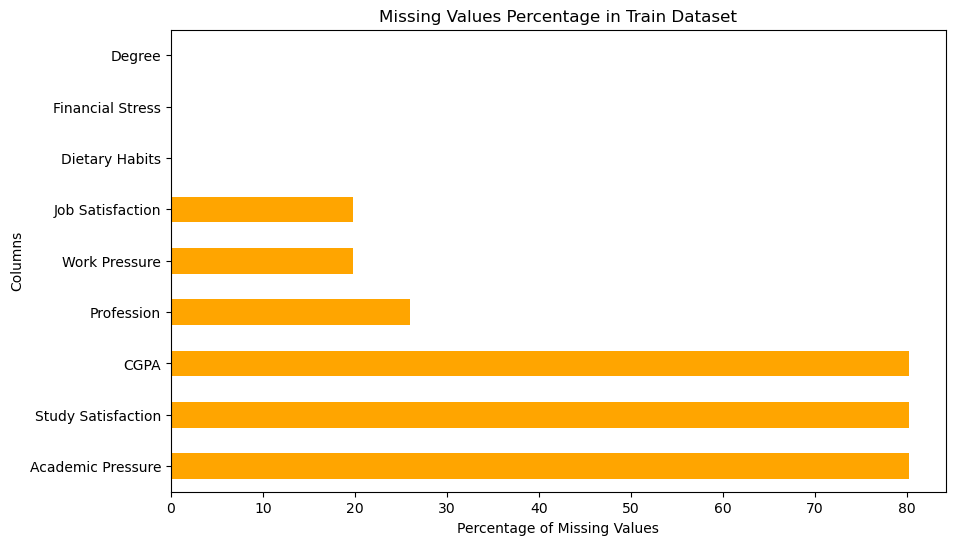

In [6]:
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

plt.figure(figsize=(10, 6))
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind="barh", color="orange")
plt.title("Missing Values Percentage in Train Dataset")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.show()

In [7]:
high_missing_threshold = 80
columns_to_drop = missing_percentage[missing_percentage > high_missing_threshold].index.tolist()
print(f"Columns with >{high_missing_threshold}% missing values: {columns_to_drop}")

Columns with >80% missing values: ['Academic Pressure', 'CGPA', 'Study Satisfaction']


In [8]:
train_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [9]:
categorical_cols = train_df.select_dtypes(include=['object']).columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

In [10]:
for col in categorical_cols:
    if train_df[col].isnull().sum() > 0:
        most_frequent = train_df[col].mode()[0]  # Find the most frequent category
        train_df[col].fillna(most_frequent, inplace=True)
        test_df[col].fillna(most_frequent, inplace=True)


In [11]:
for col in numerical_cols:
    if train_df[col].isnull().sum() > 0:
        median_value = train_df[col].median()
        train_df[col].fillna(median_value, inplace=True)
        test_df[col].fillna(median_value, inplace=True)

In [12]:
print("\nRemaining Missing Values in Train Dataset:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])



Remaining Missing Values in Train Dataset:
Series([], dtype: int64)


In [13]:
print("\nRemaining Missing Values in Test Dataset:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])


Remaining Missing Values in Test Dataset:
Series([], dtype: int64)


# ---

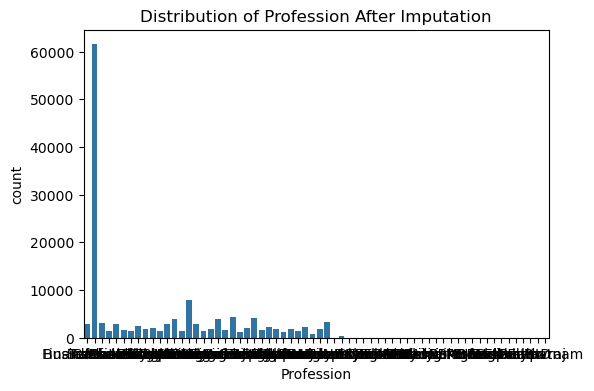

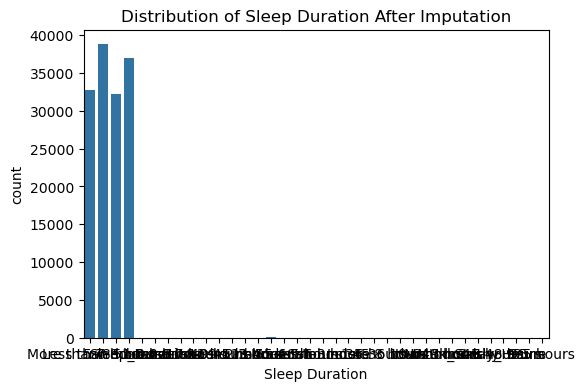

In [14]:
for col in ['Profession', 'Sleep Duration']:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x=col)
    plt.title(f"Distribution of {col} After Imputation")
    plt.show()

In [15]:
def categorize_hours(hours):
    if hours <= 4:
        return 'Low'
    elif hours <= 8:
        return 'Medium'
    else:
        return 'High'

In [16]:
train_df['WorkHoursCategory'] = train_df['Work/Study Hours'].apply(categorize_hours)
test_df['WorkHoursCategory'] = test_df['Work/Study Hours'].apply(categorize_hours)

In [17]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Select categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Fit on train and transform both train and test
train_df[categorical_cols] = ordinal_encoder.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = ordinal_encoder.transform(test_df[categorical_cols])


In [18]:
scaler = StandardScaler()
numeric_features = ['Age', 'Work Pressure', 'Work/Study Hours', 'Financial Stress']
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# Data visualisation

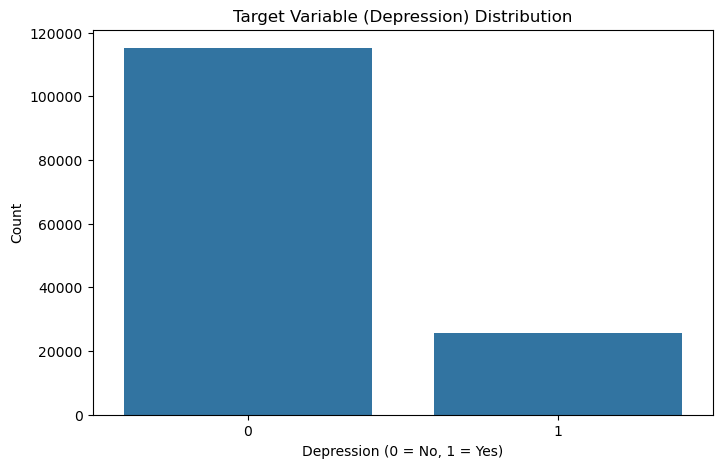

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Depression', data=train_df)
plt.title("Target Variable (Depression) Distribution")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


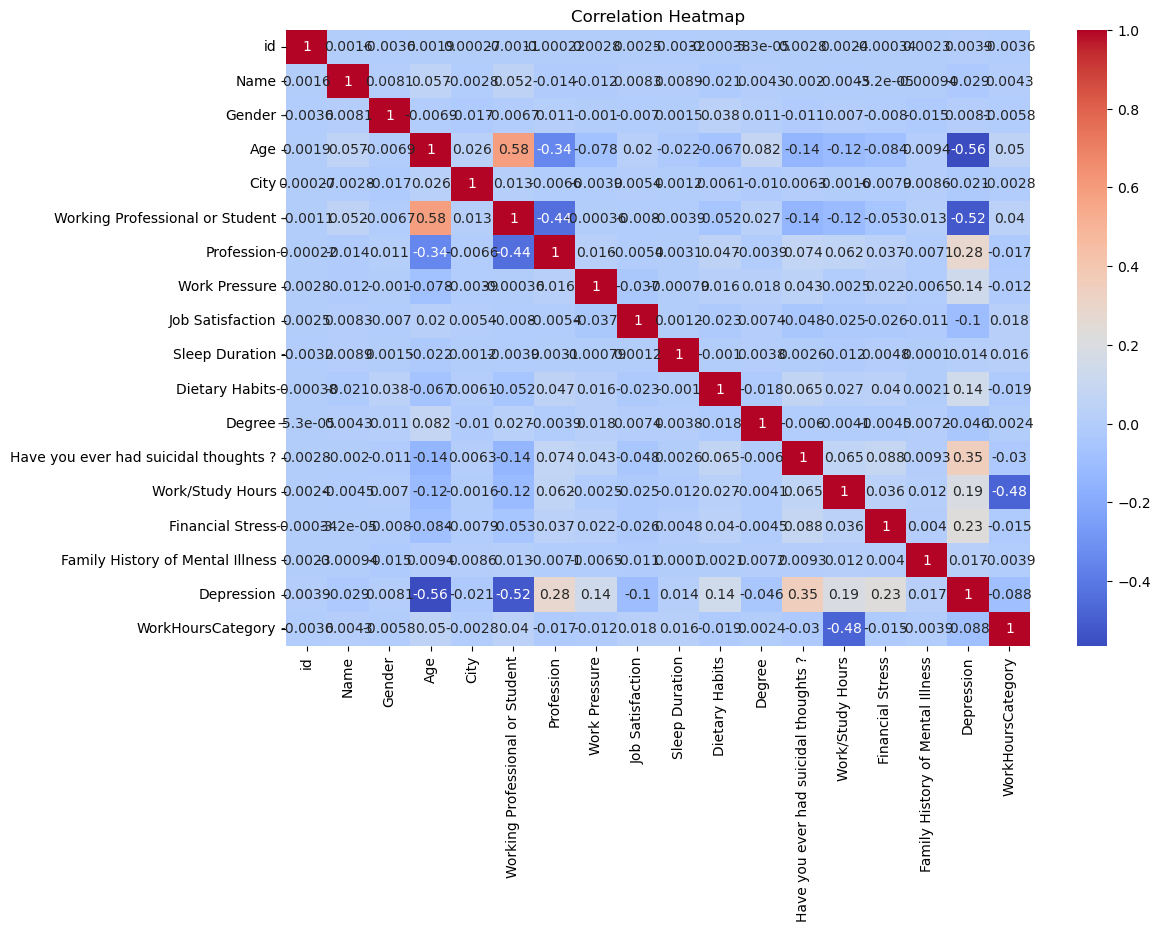

In [20]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [21]:
# # Pair Plot for Key Features
# sns.pairplot(train_df, vars=['Age', 'Work Pressure', 'Job Satisfaction', 'Financial Stress'], hue='Depression')
# plt.suptitle("Pair Plot of Key Features", y=1.02)
# plt.show()


# Model Testing

In [22]:
X = train_df.drop(columns=['id', 'Depression', 'Name'])
y = train_df['Depression']
X_test = test_df.drop(columns=['id', 'Name'])

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
}

In [24]:
results = {}
for name, model in models.items():
    metrics = {"Accuracy": [], "F1 Score": [], "ROC AUC": []}
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        probs = model.predict_proba(X_val)[:, 1]

        metrics["Accuracy"].append(accuracy_score(y_val, preds))
        metrics["F1 Score"].append(f1_score(y_val, preds))
        metrics["ROC AUC"].append(roc_auc_score(y_val, probs))
    
    results[name] = {metric: np.mean(values) for metric, values in metrics.items()}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20454, number of negative: 92106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181716 -> initscore=-1.504762
[LightGBM] [Info] Start training from score -1.504762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20454, number of negative: 92106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

In [25]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
              Accuracy  F1 Score   ROC AUC
RandomForest  0.927783  0.795811  0.965321
LightGBM      0.930682  0.808347  0.969476
XGBoost       0.929502  0.804558  0.968400
CatBoost      0.930498  0.806832  0.969850


# Final Model

In [26]:
best_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
    ('lgbm', LGBMClassifier(random_state=RANDOM_STATE)),
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE, verbose=0))
]

stacking_model = StackingClassifier(
    estimators=best_models,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE)
)

In [27]:
stacking_model.fit(X, y)
stacked_preds = stacking_model.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25567, number of negative: 115133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 140700, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181713 -> initscore=-1.504786
[LightGBM] [Info] Start training from score -1.504786
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20454, number of negative: 92106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Inf

# SHAP analysis

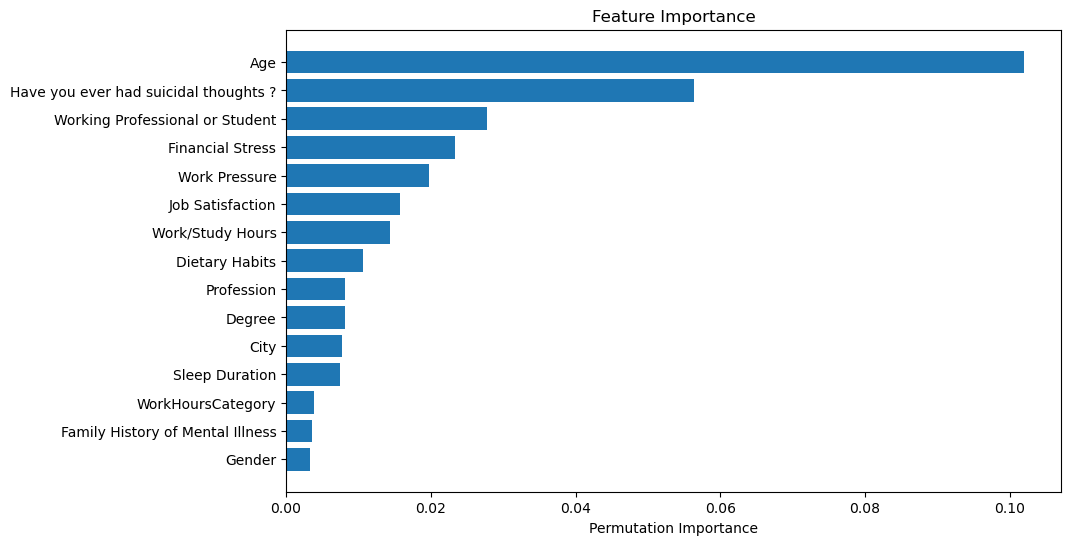

In [30]:
from sklearn.inspection import permutation_importance

# Permutation Feature Importance
result = permutation_importance(stacking_model, X, y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()



# Submission

In [31]:
submission_df['Depression'] = stacked_preds
submission_df.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!
